# Exploratory Data Analysis

#### Importing Necessary Libraries

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## MAGIC KINGDOM

### 7 Dwarfs Mine Train

In [253]:
df_mk_7dwarfs = pd.read_csv("data/7_dwarfs_train.csv")
df_mk_7dwarfs

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...
321626,12/28/2021,2021-12-28 22:42:15,NaN,45.0
321627,12/28/2021,2021-12-28 22:48:12,NaN,45.0
321628,12/28/2021,2021-12-28 22:54:10,NaN,45.0
321629,12/28/2021,2021-12-28 22:54:28,10.0,NaN


In [254]:
df_mk_7dwarfs = df_mk_7dwarfs[["datetime","SPOSTMIN"]].copy()


In [255]:
df_mk_7dwarfs.isna().sum()

datetime       0
SPOSTMIN    7635
dtype: int64

In [256]:
df_mk_7dwarfs = df_mk_7dwarfs.dropna()

In [257]:
df_mk_7dwarfs.isna().sum()

datetime    0
SPOSTMIN    0
dtype: int64

In [258]:
df_mk_7dwarfs

,datetime,SPOSTMIN
0,2015-01-01 07:51:12,45.0
1,2015-01-01 08:02:13,60.0
3,2015-01-01 08:09:12,60.0
4,2015-01-01 08:16:12,60.0
6,2015-01-01 08:23:12,60.0
...,...,...
321625,2021-12-28 22:36:08,45.0
321626,2021-12-28 22:42:15,45.0
321627,2021-12-28 22:48:12,45.0
321628,2021-12-28 22:54:10,45.0


In [259]:
# df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN == -999] = np.nan


In [260]:
df_mk_7dwarfs['datetime'] = pd.to_datetime(df_mk_7dwarfs.datetime)
df_mk_7dwarfs.set_index('datetime', inplace=True)


In [261]:
df_mk_7dwarfs = df_mk_7dwarfs['SPOSTMIN']

In [262]:
df_mk_7dwarfs

datetime
2015-01-01 07:51:12    45.0
2015-01-01 08:02:13    60.0
2015-01-01 08:09:12    60.0
2015-01-01 08:16:12    60.0
2015-01-01 08:23:12    60.0
                       ... 
2021-12-28 22:36:08    45.0
2021-12-28 22:42:15    45.0
2021-12-28 22:48:12    45.0
2021-12-28 22:54:10    45.0
2021-12-28 22:57:34    35.0
Name: SPOSTMIN, Length: 313996, dtype: float64

In [263]:
df_mk_7dwarfs_daily = df_mk_7dwarfs.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

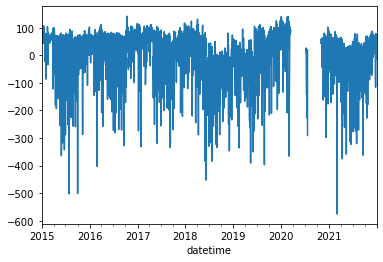

In [264]:
df_mk_7dwarfs_daily.plot()

In [265]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.loc['2015-01-01 07:51:12':'2019-12-31 23:55:02']

In [266]:
df_mk_7dwarfs_daily.isna().sum()

2

In [267]:
df_mk_7dwarfs_daily

datetime
2015-01-02    106.040000
2015-01-03     93.835938
2015-01-04     80.720000
2015-01-05     87.370690
2015-01-06     79.615385
                 ...    
2019-12-27     92.446809
2019-12-28     34.654676
2019-12-29     94.202899
2019-12-30     20.920290
2019-12-31    134.654088
Freq: D, Name: SPOSTMIN, Length: 1825, dtype: float64

<AxesSubplot:xlabel='datetime'>

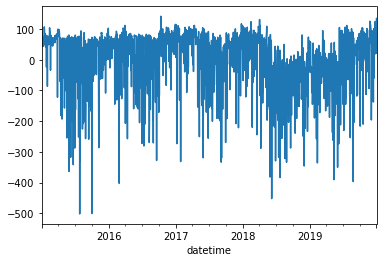

In [268]:
df_mk_7dwarfs_daily.plot()

In [272]:
df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.fillna(method='ffill')

In [273]:
# df_mk_7dwarfs_daily = df_mk_7dwarfs_daily.ffill()[(df_mk_7dwarfs_daily.index > '2015-01-01') 
#                  & (df_mk_7dwarfs_daily.index < '2021-12-12')


In [274]:
df_mk_7dwarfs_daily.isna().sum()

0

In [275]:
df_mk_7dwarfs_daily

datetime
2015-01-02    106.040000
2015-01-03     93.835938
2015-01-04     80.720000
2015-01-05     87.370690
2015-01-06     79.615385
                 ...    
2019-12-27     92.446809
2019-12-28     34.654676
2019-12-29     94.202899
2019-12-30     20.920290
2019-12-31    134.654088
Freq: D, Name: SPOSTMIN, Length: 1825, dtype: float64

In [276]:
# df_mk_7dwarfs = df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN != -999]
# df_mk_7dwarfs

<AxesSubplot:xlabel='datetime'>

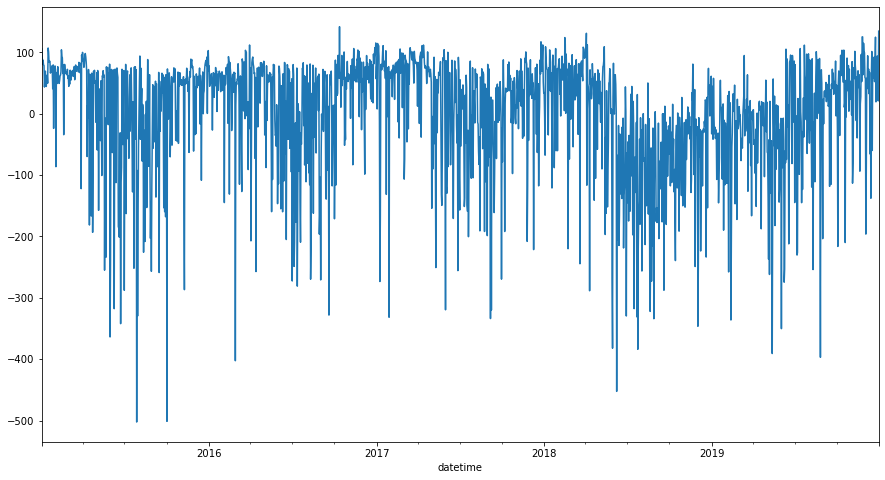

In [278]:
df_mk_7dwarfs_daily.plot(figsize=(15,8))

In [282]:
df_mk_7dwarfs_daily

datetime
2015-01-02    106.040000
2015-01-03     93.835938
2015-01-04     80.720000
2015-01-05     87.370690
2015-01-06     79.615385
                 ...    
2019-12-27     92.446809
2019-12-28     34.654676
2019-12-29     94.202899
2019-12-30     20.920290
2019-12-31    134.654088
Freq: D, Name: SPOSTMIN, Length: 1825, dtype: float64

In [56]:
# df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN == -999] = "NaN"

<ipython-input-56-8d7aabfa93e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mk_7dwarfs[df_mk_7dwarfs.SPOSTMIN == -999] = "NaN"


In [13]:
# pvalue = adfuller(df_mk_7dwarfs_daily)[1]
# is_stationary = pvalue<= .05

# is_stationary

In [14]:
model = ARIMA(df_mk_7dwarfs_daily, order=(2,0,1))


res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               SPOSTMIN   No. Observations:                 2554
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9545.008
Date:                Wed, 23 Feb 2022   AIC                          19100.016
Time:                        16:30:00   BIC                          19129.243
Sample:                    01-01-2015   HQIC                         19110.615
                         - 12-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.4626      2.504     30.539      0.000      71.555      81.370
ar.L1          0.7483      0.029     26.001      0.000       0.692       0.805
ar.L2          0.1942      0.025      7.907      0.000       0.146       0.242
ma.L1         -0.5093      0.027    -19.169      0.000      -0.561      -0.457
sigma2       208.3980      4.990     41.765      0.000     198.618     218.178
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               339.99
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pirates of the Caribbean

In [15]:
df_mk_pirates = pd.read_csv("data/pirates_of_caribbean.csv")
df_mk_pirates

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 08:27:58,NaN,-999.0
1,01/01/2015,2015-01-01 08:56:55,NaN,-999.0
2,01/01/2015,2015-01-01 08:57:38,NaN,-999.0
3,01/01/2015,2015-01-01 08:58:34,NaN,-999.0
4,01/01/2015,2015-01-01 09:24:55,NaN,-999.0
...,...,...,...,...
301941,12/28/2021,2021-12-28 22:35:34,NaN,5.0
301942,12/28/2021,2021-12-28 22:42:15,NaN,5.0
301943,12/28/2021,2021-12-28 22:48:12,NaN,5.0
301944,12/28/2021,2021-12-28 22:54:10,NaN,5.0


In [16]:
df_mk_pirates= df_mk_pirates[df_mk_pirates.SPOSTMIN != -999]
df_mk_pirates

,date,datetime,SACTMIN,SPOSTMIN
5,01/01/2015,2015-01-01 10:19:36,NaN,10.0
6,01/01/2015,2015-01-01 10:22:13,3.0,NaN
7,01/01/2015,2015-01-01 10:29:13,NaN,15.0
8,01/01/2015,2015-01-01 10:36:39,NaN,25.0
9,01/01/2015,2015-01-01 10:37:13,NaN,25.0
...,...,...,...,...
301941,12/28/2021,2021-12-28 22:35:34,NaN,5.0
301942,12/28/2021,2021-12-28 22:42:15,NaN,5.0
301943,12/28/2021,2021-12-28 22:48:12,NaN,5.0
301944,12/28/2021,2021-12-28 22:54:10,NaN,5.0


In [17]:
df_mk_pirates['datetime'] = pd.to_datetime(df_mk_pirates.datetime)
df_mk_pirates.set_index('datetime', inplace=True)
df_mk_pirates = df_mk_pirates['SPOSTMIN']
df_mk_pirates

<ipython-input-17-9ca486875928>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mk_pirates['datetime'] = pd.to_datetime(df_mk_pirates.datetime)


datetime
2015-01-01 10:19:36    10.0
2015-01-01 10:22:13     NaN
2015-01-01 10:29:13    15.0
2015-01-01 10:36:39    25.0
2015-01-01 10:37:13    25.0
                       ... 
2021-12-28 22:35:34     5.0
2021-12-28 22:42:15     5.0
2021-12-28 22:48:12     5.0
2021-12-28 22:54:10     5.0
2021-12-28 23:00:27     5.0
Name: SPOSTMIN, Length: 280031, dtype: float64

In [18]:
df_mk_pirates.isna().sum()

11589

In [19]:
df_mk_pirates = df_mk_pirates.dropna()

In [20]:
df_mk_pirates_daily = df_mk_pirates.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

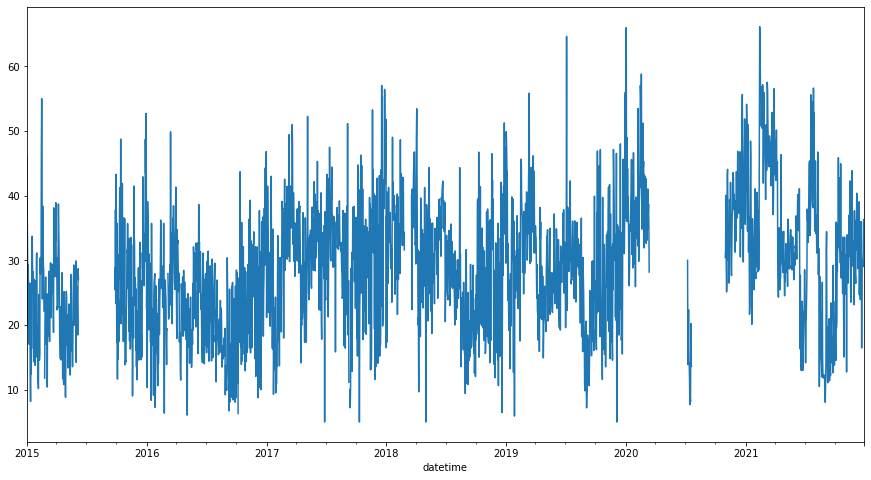

In [21]:
df_mk_pirates_daily.plot(figsize=(15,8))

### Splash Mountain

In [22]:
df_mk_splash = pd.read_csv("data/splash_mountain.csv")
df_mk_splash

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,5.0
1,01/01/2015,2015-01-01 08:02:13,NaN,5.0
2,01/01/2015,2015-01-01 08:09:12,NaN,5.0
3,01/01/2015,2015-01-01 08:16:12,NaN,5.0
4,01/01/2015,2015-01-01 08:23:12,NaN,5.0
...,...,...,...,...
287943,12/28/2021,2021-12-28 22:35:34,NaN,15.0
287944,12/28/2021,2021-12-28 22:42:15,NaN,15.0
287945,12/28/2021,2021-12-28 22:48:12,NaN,15.0
287946,12/28/2021,2021-12-28 22:54:10,NaN,15.0


In [23]:
df_mk_splash= df_mk_splash[df_mk_splash.SPOSTMIN != -999]
df_mk_splash

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,5.0
1,01/01/2015,2015-01-01 08:02:13,NaN,5.0
2,01/01/2015,2015-01-01 08:09:12,NaN,5.0
3,01/01/2015,2015-01-01 08:16:12,NaN,5.0
4,01/01/2015,2015-01-01 08:23:12,NaN,5.0
...,...,...,...,...
287943,12/28/2021,2021-12-28 22:35:34,NaN,15.0
287944,12/28/2021,2021-12-28 22:42:15,NaN,15.0
287945,12/28/2021,2021-12-28 22:48:12,NaN,15.0
287946,12/28/2021,2021-12-28 22:54:10,NaN,15.0


In [24]:
df_mk_splash['datetime'] = pd.to_datetime(df_mk_splash.datetime)
df_mk_splash.set_index('datetime', inplace=True)
df_mk_splash = df_mk_splash['SPOSTMIN']
df_mk_splash

<ipython-input-24-f801c80f8e24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mk_splash['datetime'] = pd.to_datetime(df_mk_splash.datetime)


datetime
2015-01-01 07:51:12     5.0
2015-01-01 08:02:13     5.0
2015-01-01 08:09:12     5.0
2015-01-01 08:16:12     5.0
2015-01-01 08:23:12     5.0
                       ... 
2021-12-28 22:35:34    15.0
2021-12-28 22:42:15    15.0
2021-12-28 22:48:12    15.0
2021-12-28 22:54:10    15.0
2021-12-28 23:00:27    15.0
Name: SPOSTMIN, Length: 255910, dtype: float64

In [25]:
df_mk_splash = df_mk_splash.dropna()

In [26]:
df_mk_splash.isna().sum()

0

In [27]:
df_mk_splash_daily = df_mk_splash.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

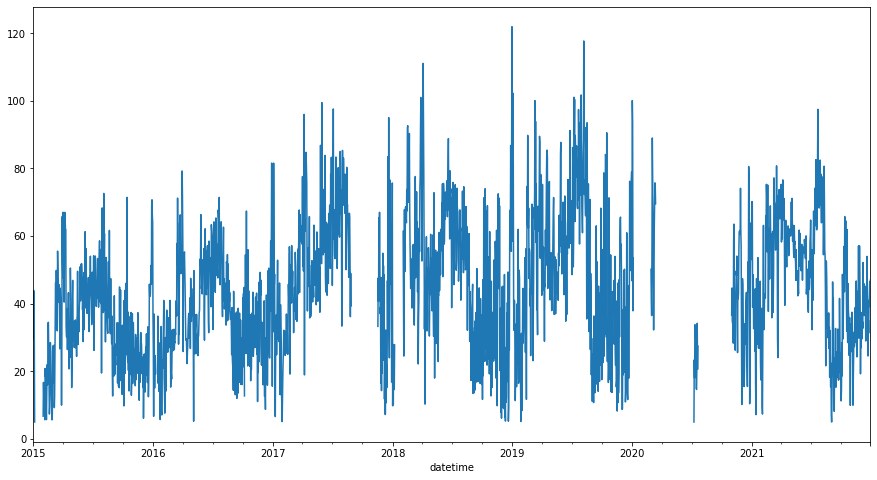

In [28]:
df_mk_splash_daily.plot(figsize=(15,8))

## ANIMAL KINGDOM

### Dinosaur Ride

In [29]:
df_ak_dinosaur = pd.read_csv("data/dinosaur.csv")
df_ak_dinosaur

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,10.0
4,01/01/2015,2015-01-01 08:19:26,NaN,10.0
...,...,...,...,...
252398,12/28/2021,2021-12-28 19:36:10,NaN,10.0
252399,12/28/2021,2021-12-28 19:42:15,NaN,10.0
252400,12/28/2021,2021-12-28 19:48:15,NaN,10.0
252401,12/28/2021,2021-12-28 19:54:10,NaN,10.0


In [30]:
df_ak_dinosaur= df_ak_dinosaur[df_ak_dinosaur.SPOSTMIN != -999]
df_ak_dinosaur

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,10.0
4,01/01/2015,2015-01-01 08:19:26,NaN,10.0
...,...,...,...,...
252398,12/28/2021,2021-12-28 19:36:10,NaN,10.0
252399,12/28/2021,2021-12-28 19:42:15,NaN,10.0
252400,12/28/2021,2021-12-28 19:48:15,NaN,10.0
252401,12/28/2021,2021-12-28 19:54:10,NaN,10.0


In [31]:
df_ak_dinosaur['datetime'] = pd.to_datetime(df_ak_dinosaur.datetime)
df_ak_dinosaur.set_index('datetime', inplace=True)
df_ak_dinosaur = df_ak_dinosaur['SPOSTMIN']
df_ak_dinosaur

<ipython-input-31-3ffe4aee81a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ak_dinosaur['datetime'] = pd.to_datetime(df_ak_dinosaur.datetime)


datetime
2015-01-01 07:47:26     5.0
2015-01-01 07:54:23     5.0
2015-01-01 08:05:33     5.0
2015-01-01 08:12:23    10.0
2015-01-01 08:19:26    10.0
                       ... 
2021-12-28 19:36:10    10.0
2021-12-28 19:42:15    10.0
2021-12-28 19:48:15    10.0
2021-12-28 19:54:10    10.0
2021-12-28 20:00:25    10.0
Name: SPOSTMIN, Length: 233683, dtype: float64

In [32]:
df_ak_dinosaur = df_ak_dinosaur.dropna()

In [33]:
df_ak_dinosaur.isna().sum()

0

In [34]:
df_ak_dinosaur_daily = df_ak_dinosaur.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

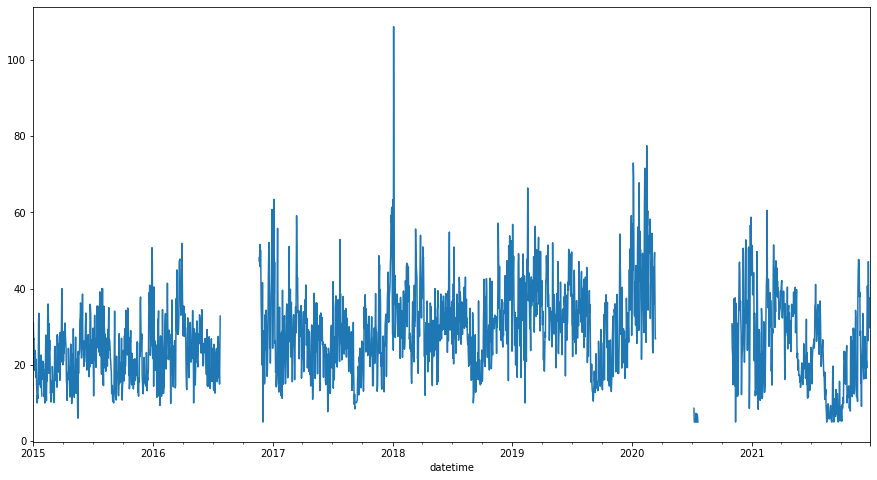

In [35]:
df_ak_dinosaur_daily.plot(figsize=(15,8))

### Expedition Everest

In [36]:
df_ak_everest =pd.read_csv("data/expedition_everest.csv")
df_ak_everest

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,5.0
4,01/01/2015,2015-01-01 08:19:26,NaN,5.0
...,...,...,...,...
275269,12/28/2021,2021-12-28 19:36:10,NaN,20.0
275270,12/28/2021,2021-12-28 19:42:15,NaN,20.0
275271,12/28/2021,2021-12-28 19:48:15,NaN,20.0
275272,12/28/2021,2021-12-28 19:52:06,NaN,5.0


In [37]:
df_ak_everest = df_ak_everest[df_ak_everest.SPOSTMIN != -999]
df_ak_everest

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,5.0
4,01/01/2015,2015-01-01 08:19:26,NaN,5.0
...,...,...,...,...
275269,12/28/2021,2021-12-28 19:36:10,NaN,20.0
275270,12/28/2021,2021-12-28 19:42:15,NaN,20.0
275271,12/28/2021,2021-12-28 19:48:15,NaN,20.0
275272,12/28/2021,2021-12-28 19:52:06,NaN,5.0


In [38]:
df_ak_everest['datetime'] = pd.to_datetime(df_ak_everest.datetime)
df_ak_everest.set_index('datetime', inplace=True)
df_ak_everest = df_ak_everest['SPOSTMIN']
df_ak_everest

<ipython-input-38-67ccf0049134>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ak_everest['datetime'] = pd.to_datetime(df_ak_everest.datetime)


datetime
2015-01-01 07:47:26     5.0
2015-01-01 07:54:23     5.0
2015-01-01 08:05:33     5.0
2015-01-01 08:12:23     5.0
2015-01-01 08:19:26     5.0
                       ... 
2021-12-28 19:36:10    20.0
2021-12-28 19:42:15    20.0
2021-12-28 19:48:15    20.0
2021-12-28 19:52:06     5.0
2021-12-28 20:00:25     5.0
Name: SPOSTMIN, Length: 255172, dtype: float64

In [39]:
df_ak_everest = df_ak_everest.dropna()

In [40]:
df_ak_everest.isna().sum()

0

In [41]:
df_ak_everest_daily = df_ak_everest.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

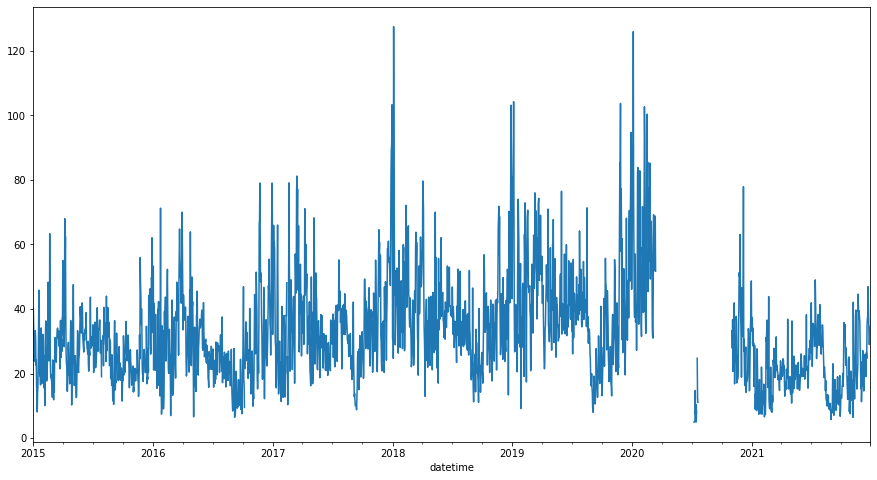

In [42]:
df_ak_everest_daily.plot(figsize=(15,8))

### Kilimajaro Safaris

In [43]:
df_ak_safari =pd.read_csv("data/kilimanjaro_safaris.csv")
df_ak_safari

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,10.0
4,01/01/2015,2015-01-01 08:19:26,NaN,10.0
...,...,...,...,...
257780,12/28/2021,2021-12-28 19:30:15,NaN,-999.0
257781,12/28/2021,2021-12-28 19:36:10,NaN,-999.0
257782,12/28/2021,2021-12-28 19:42:15,NaN,-999.0
257783,12/28/2021,2021-12-28 19:48:15,NaN,-999.0


In [44]:
df_ak_safari = df_ak_safari[df_ak_safari.SPOSTMIN != -999]
df_ak_safari

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:47:26,NaN,5.0
1,01/01/2015,2015-01-01 07:54:23,NaN,5.0
2,01/01/2015,2015-01-01 08:05:33,NaN,5.0
3,01/01/2015,2015-01-01 08:12:23,NaN,10.0
4,01/01/2015,2015-01-01 08:19:26,NaN,10.0
...,...,...,...,...
257748,12/28/2021,2021-12-28 16:18:11,NaN,60.0
257749,12/28/2021,2021-12-28 16:19:33,NaN,55.0
257750,12/28/2021,2021-12-28 16:30:15,NaN,55.0
257751,12/28/2021,2021-12-28 16:35:54,NaN,55.0


In [45]:
df_ak_safari['datetime'] = pd.to_datetime(df_ak_safari.datetime)
df_ak_safari.set_index('datetime', inplace=True)
df_ak_safari = df_ak_safari['SPOSTMIN']
df_ak_safari

<ipython-input-45-ad9a8ad206c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ak_safari['datetime'] = pd.to_datetime(df_ak_safari.datetime)


datetime
2015-01-01 07:47:26     5.0
2015-01-01 07:54:23     5.0
2015-01-01 08:05:33     5.0
2015-01-01 08:12:23    10.0
2015-01-01 08:19:26    10.0
                       ... 
2021-12-28 16:18:11    60.0
2021-12-28 16:19:33    55.0
2021-12-28 16:30:15    55.0
2021-12-28 16:35:54    55.0
2021-12-28 16:40:47    45.0
Name: SPOSTMIN, Length: 243752, dtype: float64

In [46]:
df_ak_safari = df_ak_safari.dropna()

In [47]:
df_ak_safari.isna().sum()

0

In [48]:
df_ak_safari_daily = df_ak_safari.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

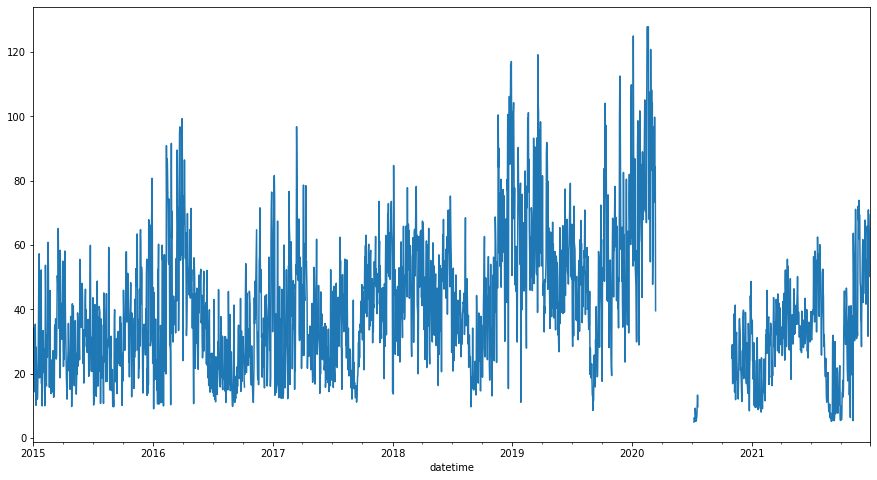

In [49]:
df_ak_safari_daily.plot(figsize=(15,8))

### Navi River

In [50]:
df_ak_naviriver = pd.read_csv("data/navi_river.csv")
df_ak_naviriver

,date,datetime,SACTMIN,SPOSTMIN
0,05/26/2017,2017-05-26 09:09:46,NaN,-999.0
1,05/26/2017,2017-05-26 09:10:12,NaN,5.0
2,05/26/2017,2017-05-26 09:17:09,NaN,45.0
3,05/26/2017,2017-05-26 09:24:07,NaN,45.0
4,05/26/2017,2017-05-26 09:30:10,NaN,45.0
...,...,...,...,...
182116,12/28/2021,2021-12-28 19:32:23,NaN,60.0
182117,12/28/2021,2021-12-28 19:42:15,NaN,60.0
182118,12/28/2021,2021-12-28 19:47:09,NaN,30.0
182119,12/28/2021,2021-12-28 19:54:10,NaN,30.0


In [51]:
df_ak_naviriver = df_ak_naviriver[df_ak_naviriver.SPOSTMIN != -999]
df_ak_naviriver

,date,datetime,SACTMIN,SPOSTMIN
1,05/26/2017,2017-05-26 09:10:12,NaN,5.0
2,05/26/2017,2017-05-26 09:17:09,NaN,45.0
3,05/26/2017,2017-05-26 09:24:07,NaN,45.0
4,05/26/2017,2017-05-26 09:30:10,NaN,45.0
6,05/26/2017,2017-05-26 09:45:32,NaN,45.0
...,...,...,...,...
182116,12/28/2021,2021-12-28 19:32:23,NaN,60.0
182117,12/28/2021,2021-12-28 19:42:15,NaN,60.0
182118,12/28/2021,2021-12-28 19:47:09,NaN,30.0
182119,12/28/2021,2021-12-28 19:54:10,NaN,30.0


In [52]:
df_ak_naviriver['datetime'] = pd.to_datetime(df_ak_naviriver.datetime)
df_ak_naviriver.set_index('datetime', inplace=True)
df_ak_naviriver = df_ak_naviriver['SPOSTMIN']
df_ak_naviriver

<ipython-input-52-667d8541b413>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ak_naviriver['datetime'] = pd.to_datetime(df_ak_naviriver.datetime)


datetime
2017-05-26 09:10:12     5.0
2017-05-26 09:17:09    45.0
2017-05-26 09:24:07    45.0
2017-05-26 09:30:10    45.0
2017-05-26 09:45:32    45.0
                       ... 
2021-12-28 19:32:23    60.0
2021-12-28 19:42:15    60.0
2021-12-28 19:47:09    30.0
2021-12-28 19:54:10    30.0
2021-12-28 20:00:25    30.0
Name: SPOSTMIN, Length: 174554, dtype: float64

In [53]:
df_ak_naviriver = df_ak_naviriver.dropna()

In [54]:
df_ak_naviriver.isna().sum()

0

In [55]:
df_ak_naviriver_daily = df_ak_naviriver.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

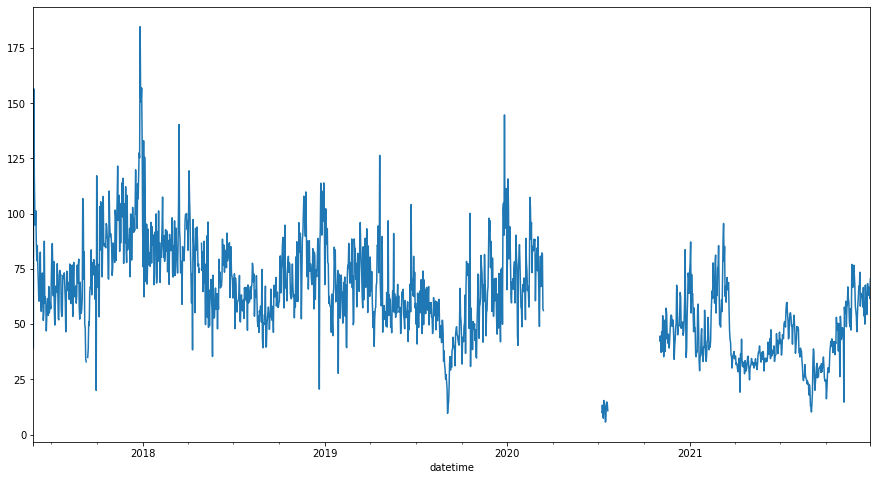

In [56]:
df_ak_naviriver_daily.plot(figsize=(15,8))

## EPCOT

### Soarin

In [57]:
df_ec_soarin = pd.read_csv("data/soarin.csv")
df_ec_soarin

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:45:15,NaN,10.0
1,01/01/2015,2015-01-01 07:52:16,NaN,10.0
2,01/01/2015,2015-01-01 08:03:17,NaN,10.0
3,01/01/2015,2015-01-01 08:10:16,NaN,35.0
4,01/01/2015,2015-01-01 08:17:19,NaN,45.0
...,...,...,...,...
274765,12/28/2021,2021-12-28 21:36:10,NaN,30.0
274766,12/28/2021,2021-12-28 21:42:16,NaN,30.0
274767,12/28/2021,2021-12-28 21:48:12,NaN,30.0
274768,12/28/2021,2021-12-28 21:54:09,NaN,30.0


In [58]:
df_ec_soarin = df_ec_soarin[df_ec_soarin.SPOSTMIN != -999]
df_ec_soarin

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:45:15,NaN,10.0
1,01/01/2015,2015-01-01 07:52:16,NaN,10.0
2,01/01/2015,2015-01-01 08:03:17,NaN,10.0
3,01/01/2015,2015-01-01 08:10:16,NaN,35.0
4,01/01/2015,2015-01-01 08:17:19,NaN,45.0
...,...,...,...,...
274765,12/28/2021,2021-12-28 21:36:10,NaN,30.0
274766,12/28/2021,2021-12-28 21:42:16,NaN,30.0
274767,12/28/2021,2021-12-28 21:48:12,NaN,30.0
274768,12/28/2021,2021-12-28 21:54:09,NaN,30.0


In [59]:
df_ec_soarin['datetime'] = pd.to_datetime(df_ec_soarin.datetime)
df_ec_soarin.set_index('datetime', inplace=True)
df_ec_soarin = df_ec_soarin['SPOSTMIN']
df_ec_soarin

<ipython-input-59-cd0074ce2a9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ec_soarin['datetime'] = pd.to_datetime(df_ec_soarin.datetime)


datetime
2015-01-01 07:45:15    10.0
2015-01-01 07:52:16    10.0
2015-01-01 08:03:17    10.0
2015-01-01 08:10:16    35.0
2015-01-01 08:17:19    45.0
                       ... 
2021-12-28 21:36:10    30.0
2021-12-28 21:42:16    30.0
2021-12-28 21:48:12    30.0
2021-12-28 21:54:09    30.0
2021-12-28 22:00:16    30.0
Name: SPOSTMIN, Length: 269468, dtype: float64

In [60]:
df_ec_soarin.dropna()

datetime
2015-01-01 07:45:15    10.0
2015-01-01 07:52:16    10.0
2015-01-01 08:03:17    10.0
2015-01-01 08:10:16    35.0
2015-01-01 08:17:19    45.0
                       ... 
2021-12-28 21:36:10    30.0
2021-12-28 21:42:16    30.0
2021-12-28 21:48:12    30.0
2021-12-28 21:54:09    30.0
2021-12-28 22:00:16    30.0
Name: SPOSTMIN, Length: 260618, dtype: float64

In [61]:
df_ec_soarin.isna().sum()

8850

In [62]:
df_ec_soarin_daily = df_ec_soarin.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

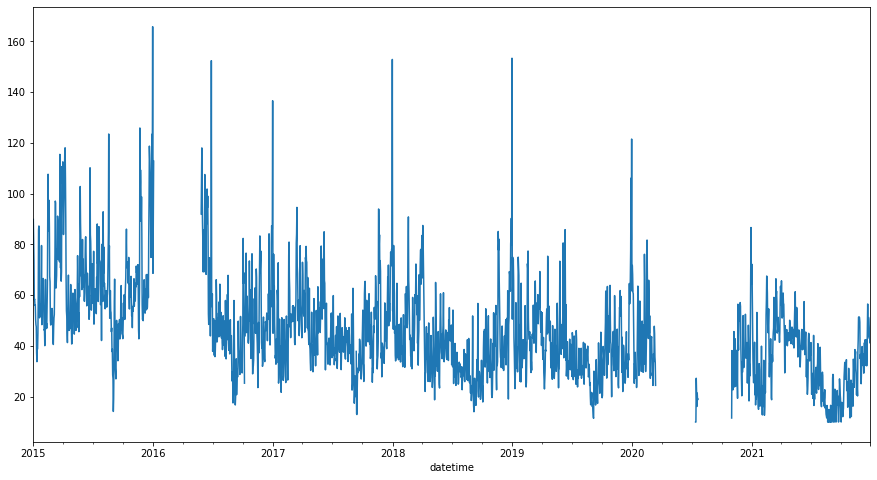

In [63]:
df_ec_soarin_daily.plot(figsize=(15,8))

### Spaceship Earth

In [64]:
df_ec_spaceship = pd.read_csv("data/spaceship_earth.csv")
df_ec_spaceship

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:45:15,NaN,5.0
1,01/01/2015,2015-01-01 07:52:16,NaN,5.0
2,01/01/2015,2015-01-01 08:38:17,NaN,5.0
3,01/01/2015,2015-01-01 08:45:15,NaN,5.0
4,01/01/2015,2015-01-01 08:52:15,NaN,5.0
...,...,...,...,...
277243,12/28/2021,2021-12-28 21:35:47,NaN,20.0
277244,12/28/2021,2021-12-28 21:42:16,NaN,20.0
277245,12/28/2021,2021-12-28 21:46:40,NaN,5.0
277246,12/28/2021,2021-12-28 21:54:09,NaN,5.0


In [65]:
df_ec_spaceship = df_ec_spaceship[df_ec_spaceship.SPOSTMIN != -999]
df_ec_spaceship

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:45:15,NaN,5.0
1,01/01/2015,2015-01-01 07:52:16,NaN,5.0
2,01/01/2015,2015-01-01 08:38:17,NaN,5.0
3,01/01/2015,2015-01-01 08:45:15,NaN,5.0
4,01/01/2015,2015-01-01 08:52:15,NaN,5.0
...,...,...,...,...
277243,12/28/2021,2021-12-28 21:35:47,NaN,20.0
277244,12/28/2021,2021-12-28 21:42:16,NaN,20.0
277245,12/28/2021,2021-12-28 21:46:40,NaN,5.0
277246,12/28/2021,2021-12-28 21:54:09,NaN,5.0


In [66]:
df_ec_spaceship['datetime'] = pd.to_datetime(df_ec_spaceship.datetime)
df_ec_spaceship.set_index('datetime', inplace=True)
df_ec_spaceship = df_ec_spaceship['SPOSTMIN']
df_ec_spaceship

<ipython-input-66-d62cdc9d48e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ec_spaceship['datetime'] = pd.to_datetime(df_ec_spaceship.datetime)


datetime
2015-01-01 07:45:15     5.0
2015-01-01 07:52:16     5.0
2015-01-01 08:38:17     5.0
2015-01-01 08:45:15     5.0
2015-01-01 08:52:15     5.0
                       ... 
2021-12-28 21:35:47    20.0
2021-12-28 21:42:16    20.0
2021-12-28 21:46:40     5.0
2021-12-28 21:54:09     5.0
2021-12-28 22:00:16     5.0
Name: SPOSTMIN, Length: 264441, dtype: float64

In [67]:
df_ec_spaceship = df_ec_spaceship.dropna()

In [68]:
df_ec_spaceship.isna().sum()

0

In [69]:
df_ec_spaceship_daily = df_ec_spaceship.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

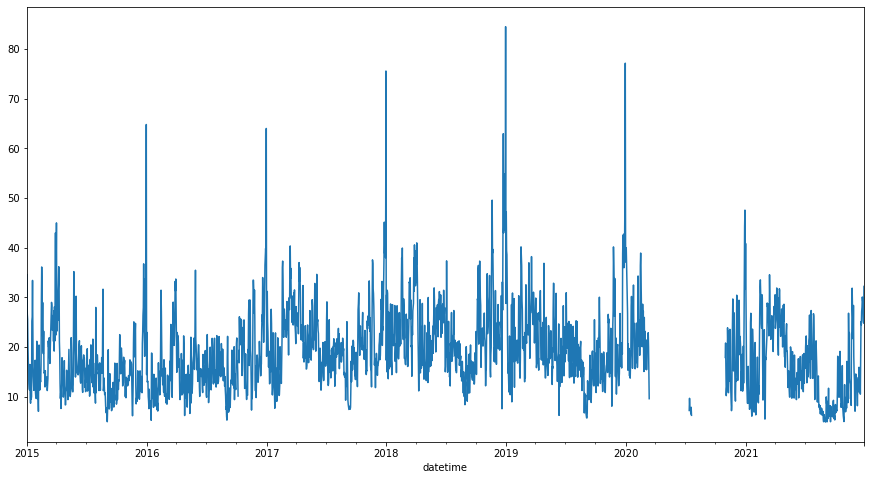

In [70]:
df_ec_spaceship_daily.plot(figsize=(15,8))

## HOLLYWOOD STUDIOS

### Slinky Dog Ride

In [71]:
df_hs_slinky = pd.read_csv("data/slinky_dog.csv")
df_hs_slinky

,date,datetime,SACTMIN,SPOSTMIN
0,06/30/2018,2018-06-30 07:44:06,NaN,270.0
1,06/30/2018,2018-06-30 07:51:06,NaN,270.0
2,06/30/2018,2018-06-30 07:58:07,NaN,270.0
3,06/30/2018,2018-06-30 08:02:08,NaN,270.0
4,06/30/2018,2018-06-30 08:09:06,NaN,270.0
...,...,...,...,...
135941,12/28/2021,2021-12-28 20:32:16,NaN,75.0
135942,12/28/2021,2021-12-28 20:40:57,NaN,75.0
135943,12/28/2021,2021-12-28 20:46:27,NaN,70.0
135944,12/28/2021,2021-12-28 20:48:31,NaN,65.0


In [72]:
df_hs_slinky = df_hs_slinky[df_hs_slinky.SPOSTMIN != -999]
df_hs_slinky

,date,datetime,SACTMIN,SPOSTMIN
0,06/30/2018,2018-06-30 07:44:06,NaN,270.0
1,06/30/2018,2018-06-30 07:51:06,NaN,270.0
2,06/30/2018,2018-06-30 07:58:07,NaN,270.0
3,06/30/2018,2018-06-30 08:02:08,NaN,270.0
4,06/30/2018,2018-06-30 08:09:06,NaN,270.0
...,...,...,...,...
135941,12/28/2021,2021-12-28 20:32:16,NaN,75.0
135942,12/28/2021,2021-12-28 20:40:57,NaN,75.0
135943,12/28/2021,2021-12-28 20:46:27,NaN,70.0
135944,12/28/2021,2021-12-28 20:48:31,NaN,65.0


In [73]:
df_hs_slinky['datetime'] = pd.to_datetime(df_hs_slinky.datetime)
df_hs_slinky.set_index('datetime', inplace=True)
df_hs_slinky = df_hs_slinky['SPOSTMIN']
df_hs_slinky

<ipython-input-73-05cdeffcf89b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hs_slinky['datetime'] = pd.to_datetime(df_hs_slinky.datetime)


datetime
2018-06-30 07:44:06    270.0
2018-06-30 07:51:06    270.0
2018-06-30 07:58:07    270.0
2018-06-30 08:02:08    270.0
2018-06-30 08:09:06    270.0
                       ...  
2021-12-28 20:32:16     75.0
2021-12-28 20:40:57     75.0
2021-12-28 20:46:27     70.0
2021-12-28 20:48:31     65.0
2021-12-28 21:00:21     65.0
Name: SPOSTMIN, Length: 125289, dtype: float64

In [74]:
df_hs_slinky = df_hs_slinky.dropna()

In [75]:
df_hs_slinky.isna().sum()

0

In [76]:
df_hs_slinky_daily = df_hs_slinky.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

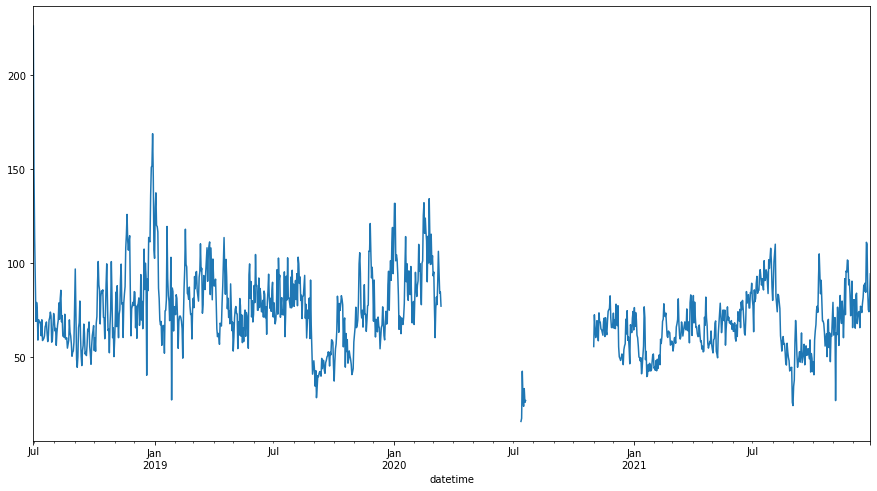

In [77]:
df_hs_slinky_daily.plot(figsize=(15,8))

### Toy Story

In [78]:
df_hs_toystory = pd.read_csv("data/toy_story_mania.csv")
df_hs_toystory

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:16,NaN,20.0
1,01/01/2015,2015-01-01 07:53:19,NaN,20.0
2,01/01/2015,2015-01-01 08:04:29,NaN,30.0
3,01/01/2015,2015-01-01 08:11:19,NaN,30.0
4,01/01/2015,2015-01-01 08:12:31,NaN,40.0
...,...,...,...,...
284165,12/28/2021,2021-12-28 20:41:30,NaN,30.0
284166,12/28/2021,2021-12-28 20:42:57,19.0,NaN
284167,12/28/2021,2021-12-28 20:44:12,NaN,25.0
284168,12/28/2021,2021-12-28 20:54:10,NaN,25.0


In [79]:
df_hs_toystory = df_hs_toystory[df_hs_toystory.SPOSTMIN != -999]
df_hs_toystory

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:16,NaN,20.0
1,01/01/2015,2015-01-01 07:53:19,NaN,20.0
2,01/01/2015,2015-01-01 08:04:29,NaN,30.0
3,01/01/2015,2015-01-01 08:11:19,NaN,30.0
4,01/01/2015,2015-01-01 08:12:31,NaN,40.0
...,...,...,...,...
284165,12/28/2021,2021-12-28 20:41:30,NaN,30.0
284166,12/28/2021,2021-12-28 20:42:57,19.0,NaN
284167,12/28/2021,2021-12-28 20:44:12,NaN,25.0
284168,12/28/2021,2021-12-28 20:54:10,NaN,25.0


In [80]:
df_hs_toystory['datetime'] = pd.to_datetime(df_hs_toystory.datetime)
df_hs_toystory.set_index('datetime', inplace=True)
df_hs_toystory = df_hs_toystory['SPOSTMIN']
df_hs_toystory

<ipython-input-80-0c6b0cc14bf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hs_toystory['datetime'] = pd.to_datetime(df_hs_toystory.datetime)


datetime
2015-01-01 07:51:16    20.0
2015-01-01 07:53:19    20.0
2015-01-01 08:04:29    30.0
2015-01-01 08:11:19    30.0
2015-01-01 08:12:31    40.0
                       ... 
2021-12-28 20:41:30    30.0
2021-12-28 20:42:57     NaN
2021-12-28 20:44:12    25.0
2021-12-28 20:54:10    25.0
2021-12-28 21:00:21    25.0
Name: SPOSTMIN, Length: 274585, dtype: float64

In [81]:
df_hs_toystory = df_hs_toystory.dropna()

In [82]:
df_hs_toystory.isna().sum()

0

In [83]:
df_hs_toystory_daily = df_hs_toystory.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

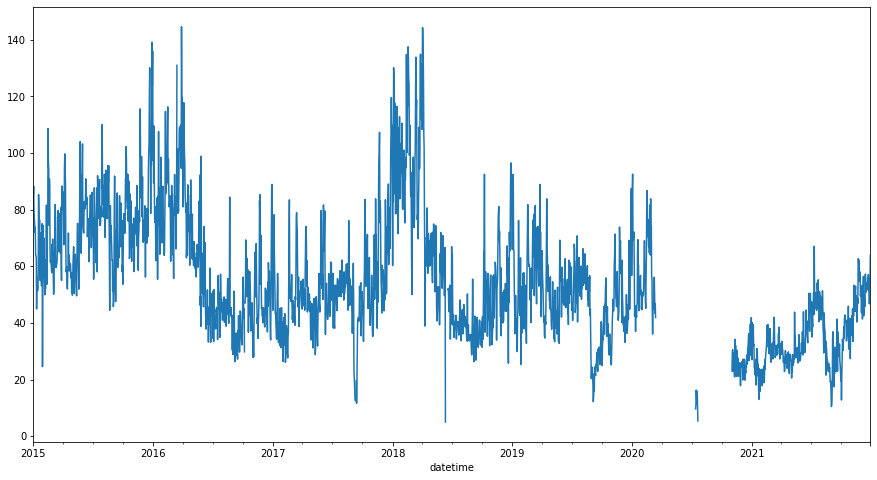

In [84]:
df_hs_toystory_daily.plot(figsize=(15,8))

### Rock -n- Roller Coaster

In [85]:
df_hs_rockin = pd.read_csv('data/rock_n_rollercoaster.csv')
df_hs_rockin 

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:46:22,NaN,5.0
1,01/01/2015,2015-01-01 07:53:19,NaN,5.0
2,01/01/2015,2015-01-01 08:04:29,NaN,20.0
3,01/01/2015,2015-01-01 08:11:19,NaN,20.0
4,01/01/2015,2015-01-01 08:16:29,NaN,20.0
...,...,...,...,...
277504,12/28/2021,2021-12-28 20:35:31,NaN,-999.0
277505,12/28/2021,2021-12-28 20:42:17,NaN,-999.0
277506,12/28/2021,2021-12-28 20:48:14,NaN,-999.0
277507,12/28/2021,2021-12-28 20:54:10,NaN,-999.0


In [86]:
df_hs_rockin = df_hs_rockin [df_hs_rockin.SPOSTMIN != -999]
df_hs_rockin 

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:46:22,NaN,5.0
1,01/01/2015,2015-01-01 07:53:19,NaN,5.0
2,01/01/2015,2015-01-01 08:04:29,NaN,20.0
3,01/01/2015,2015-01-01 08:11:19,NaN,20.0
4,01/01/2015,2015-01-01 08:16:29,NaN,20.0
...,...,...,...,...
277494,12/28/2021,2021-12-28 19:36:10,NaN,60.0
277495,12/28/2021,2021-12-28 19:42:15,NaN,60.0
277496,12/28/2021,2021-12-28 19:45:44,NaN,50.0
277497,12/28/2021,2021-12-28 19:54:10,NaN,50.0


In [87]:
df_hs_rockin['datetime'] = pd.to_datetime(df_hs_rockin.datetime)
df_hs_rockin.set_index('datetime', inplace=True)
df_hs_rockin = df_hs_rockin['SPOSTMIN']
df_hs_rockin

<ipython-input-87-b038d5c1175b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hs_rockin['datetime'] = pd.to_datetime(df_hs_rockin.datetime)


datetime
2015-01-01 07:46:22     5.0
2015-01-01 07:53:19     5.0
2015-01-01 08:04:29    20.0
2015-01-01 08:11:19    20.0
2015-01-01 08:16:29    20.0
                       ... 
2021-12-28 19:36:10    60.0
2021-12-28 19:42:15    60.0
2021-12-28 19:45:44    50.0
2021-12-28 19:54:10    50.0
2021-12-28 19:58:35    60.0
Name: SPOSTMIN, Length: 262508, dtype: float64

In [88]:
df_hs_rockin = df_hs_rockin.dropna()

In [89]:
df_hs_rockin.isna().sum()

0

In [90]:
df_hs_rockin_daily = df_hs_rockin.resample('D').mean()

<AxesSubplot:xlabel='datetime'>

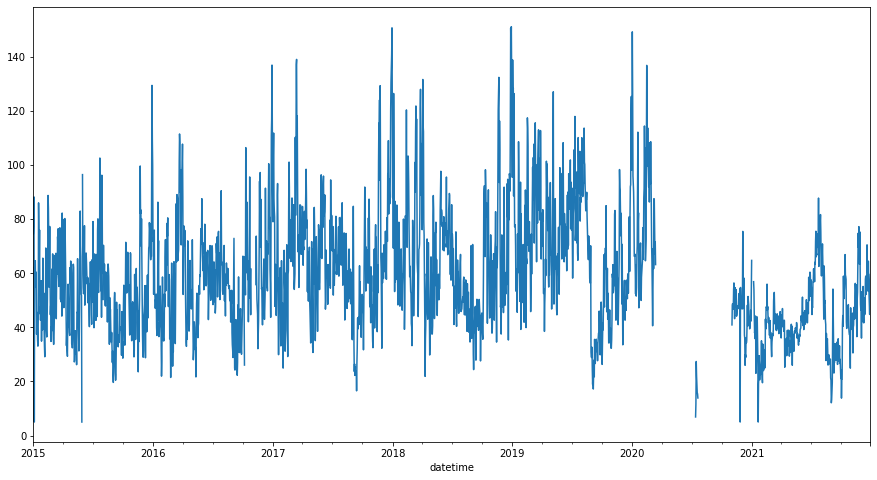

In [91]:
df_hs_rockin_daily.plot(figsize=(15,8))

### Entities for Rides

In [92]:
df_entities = pd.read_csv("data/entities.csv")    
df_entities

,code,name,short_name,land,opened_on,duration,average_wait_per_hundred
0,AK01,It's Tough to Be a Bug!,It's Tough to Be a Bug,Discovery Island,04/22/1998,8.00,12.0
1,AK07,Kilimanjaro Safaris,Kilimanjaro Safaris,Africa,04/22/1998,20.00,4.0
2,AK11,Expedition Everest - Legend of the Forbidden M...,Expedition Everest,Asia,04/07/2006,4.00,4.0
3,AK14,Kali River Rapids,Kali River Rapids,Asia,02/15/1999,10.00,5.0
4,AK18,DINOSAUR,DINOSAUR,DinoLand U.S.A.,04/22/1998,3.50,3.0
...,...,...,...,...,...,...,...
90,MK39,Astro Orbiter,Astro Orbiter,Tomorrowland,02/25/1995,1.50,13.5
91,MK40,"Monsters, Inc. Laugh Floor",Laugh Floor,Tomorrowland,04/02/2007,15.00,NaN
92,MK43,Tomorrowland Speedway,Tom'land Speedway,Tomorrowland,10/01/1971,4.25,4.5
93,MK44,Tomorrowland Transit Authority PeopleMover,PeopleMover,Tomorrowland,07/01/1975,10.00,1.5


### Medadata

In [93]:
df_metadata = pd.read_csv("data/metadata.csv")
df_metadata

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,NaN,5,0,0,1,2015,CHRISTMAS PEAK,0,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,NaN,6,1,0,1,2015,CHRISTMAS,2,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,NaN,7,2,0,1,2015,CHRISTMAS,3,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,NaN,1,3,1,1,2015,CHRISTMAS,4,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,NaN,2,4,1,1,2015,CHRISTMAS,5,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,08/27/2021,NaN,6,238,34,8,2021,NaN,11,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2075,08/28/2021,NaN,7,239,34,8,2021,NaN,10,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2076,08/29/2021,NaN,1,240,35,8,2021,NaN,9,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2077,08/30/2021,NaN,2,241,35,8,2021,NaN,8,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
